In [2]:
import os
import sys
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))  # ensures current directory is included
sys.path.append("/home/s27mhusa_hpc/Master-Thesis/XMI_Files")
import spacy
from collections import Counter
import json


In [7]:
input_label_dir = "/home/s27mhusa_hpc/Master-Thesis/RuleBasedAnnotations8thSeptember/Rule_BIO_labels_timestatement"
input_token_dir = "/home/s27mhusa_hpc/Master-Thesis/RuleBasedAnnotations8thSeptember/Rule_BIO_tokens_timestatement"


city_list_path = "/home/s27mhusa_hpc/Master-Thesis/de_cities_list.json"
region_list_path = "/home/s27mhusa_hpc/Master-Thesis/de_regions_list.json"
country_list_path = "/home/s27mhusa_hpc/Master-Thesis/countries_list.json"



all_labels = []

# Define soil-related labels to convert
soil_labels = [
    "soilAvailableNitrogen", "soilBulkDensity", "soilDepth", 
    "soilOrganicCarbon", "soilPH", "soilReferenceGroup", "soilTexture"
]

# Define labels to remove (convert to O)
remove_labels = ["cropVariety", "latitude", "longitude"]

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    # labels = eval(content)  # list of BIO labels
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        content = file.read()
    tokens = eval(content)

    i = 0
    while i < len(labels):
        label = labels[i]

        # Handle Location entities
        if label == "B-Location":
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == "I-Location":
                entity_tokens.append(j)
                j += 1
            entity_text = " ".join(tokens[k] for k in entity_tokens)
            
            # Check if entity is a known city
            if entity_text.lower() in city_list:
                labels[i] = "B-city"
                for k in entity_tokens[1:]:
                    labels[k] = "I-city"
            elif entity_text.lower() in region_list:
                labels[i] = "B-region"
                for k in entity_tokens[1:]:
                    labels[k] = "I-region"
            elif entity_text.lower() in country_list:
                labels[i] = "B-country"
                for k in entity_tokens[1:]:
                    labels[k] = "I-country"
            else:
                # If not found in any list, change as O
                labels[i] = "O"
                for k in entity_tokens[1:]:
                    labels[k] = "O"
            i = j
        
        # Handle soil-related entities
        elif any(label == f"B-{soil_label}" for soil_label in soil_labels):
            # Extract the soil label type (e.g., "soilAvailableNitrogen" from "B-soilAvailableNitrogen")
            soil_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{soil_type}":
                entity_tokens.append(j)
                j += 1
            
            # Convert to generic Soil labels
            labels[i] = "B-Soil"
            for k in entity_tokens[1:]:
                labels[k] = "I-Soil"
            i = j
        
        # Handle labels to remove (convert to O)
        elif any(label == f"B-{remove_label}" for remove_label in remove_labels):
            # Extract the label type to remove
            remove_type = label[2:]  # Remove "B-" prefix
            entity_tokens = [i]
            j = i + 1
            while j < len(labels) and labels[j] == f"I-{remove_type}":
                entity_tokens.append(j)
                j += 1
            
            # Convert all tokens of this entity to O
            for k in entity_tokens:
                labels[k] = "O"
            i = j
        else:
            i += 1

    # all_labels.extend(labels)
    with open(label_path, "w", encoding="utf-8") as file:
        file.write(str(labels))

In [8]:
from collections import Counter


all_labels = []
b_location_examples = []  # Store (label, token) pairs for B-locationName

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        token_content = file.read()
    tokens = eval(token_content)

    # Extend for overall count
    all_labels.extend(labels)

    # Collect B-locationName examples
    for label, token in zip(labels, tokens):
        if label == "I-longitude":
            b_location_examples.append((label, token))
            print(filename)

# Count only B- labels and strip B-
b_counts = Counter(label[2:] for label in all_labels if label.startswith("B-"))

# Print label counts
print("📊 B-Label Counts:")
for label, count in b_counts.items():
    print(f"{label}: {count}")

# Print all B-locationName examples
print("\n📍 Tokens with B-Soil:")
for label, token in b_location_examples:
    print(f"{label}: {token}")


📊 B-Label Counts:
Timestatement: 128
Soil: 26
locationName: 74
cropSpecies: 84

📍 Tokens with B-Soil:


In [9]:
location_names = []
filenames = []

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)

    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        tokens = eval(file.read())

    i = 0
    while i < len(labels):
        if labels[i] == "B-Timestatement":
            location_tokens = [tokens[i]]
            i += 1
            while i < len(labels) and labels[i] == "I-Timestatement":
                location_tokens.append(tokens[i])
                i += 1
            location_names.append(" ".join(location_tokens))
            filenames.append(filename)
        else:
            i += 1

# Print full location names
print("\n📍 Full Location Names:")
for loc in location_names:
    print(loc)
print("\n📍 Full filenames Names:")
for filename in filenames:
    print(filename)


📍 Full Location Names:
2018
2012
1961
2100
1961
2013
2011
2050
2011
2012
31.12.2016
01.01.1961
31.12.2099
1990
2017
1990
2017
2 Jahren
three years
2007
2016
2017
2018
2017
30.8.2017
6.9.2017
three weeks later
20.9.2017
25.9.2017
2018
24.8.2018
31.8.2018
13.9.2018
20.9.2018
2018
29.8.2018
4.9.2018
two weeks
12.9.2018
29.9.2018
1984
September 2009
four sampling seasons
long term
2017
2017
2017
2024
spring 2022
spring 2023
2019
2020
Jahr 2050
2050
2020
2050
2023
November 2023
2023
2020
2020
2020
2018
November 2023
2024
August 2024
2023
2024
2024
2012
28.05.2019
2012
end date
2012
1979
2021
1979
2021
2020
2014
2014
1985
2008
2009
2013
2013
autumn 2013
2014
one year
2015
2016
2018
2019
2019
2019
June 2019
Three - year
2006
2001
2003
2000
2020
2020
2020
2018
2019
2020
about 3.5 months
2020
50 years
51 years
2011
late summer 2011
2011
February 2018
2011
2018
2018
monitoring period
116,602 days
2018
2016
2017
2018
1396
2021
2022
2023

📍 Full filenames Names:
67631_inception_inception.txt
4196

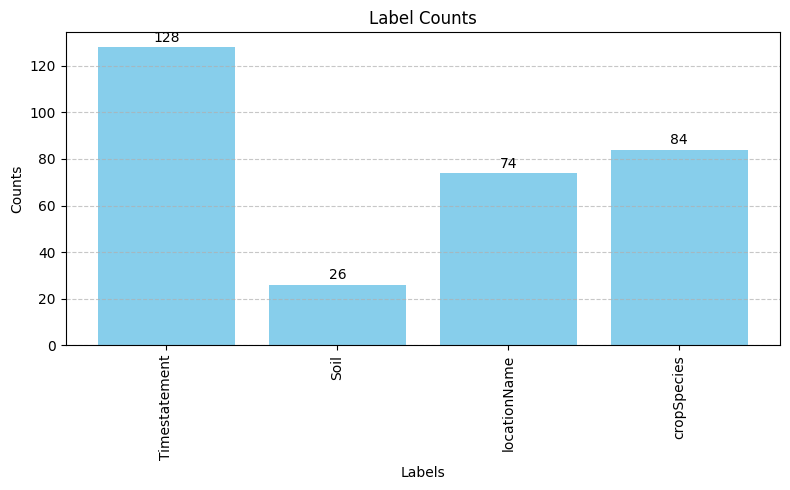

In [10]:
import matplotlib.pyplot as plt
# Extract labels and counts
labels = list(b_counts.keys())
counts = list(b_counts.values())

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='skyblue')
plt.title("Label Counts")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=90)

# Add count labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()